# Trainer() 2.0
2020.10.14

Remove the special word 'Newline token' and test on three different data sets

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

In [21]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [22]:
import pandas as pd
train_data = pd.read_csv('Data/Train_comment.csv',sep=',',encoding = "ISO-8859-1")
test_data = pd.read_csv('Data/Test_comment.csv',sep=',',encoding = "ISO-8859-1")
val_data = pd.read_csv('Data/Val_comment.csv',sep=',',encoding = "ISO-8859-1")

In [23]:
def transfer_to_int(temp):
    temp2 = []
    for i in temp:
        if i == 1.0:
            temp2.append(1)
        else:
            temp2.append(0)
    return temp2
        
train_data['attack'] = transfer_to_int(train_data['attack'])
test_data['attack'] = transfer_to_int(test_data['attack'])
val_data['attack'] = transfer_to_int(val_data['attack'])

In [24]:
def remove_token(df, target_col):
    df[target_col] = df[target_col].apply(lambda x: x.replace("newline token", " "))
#     df = df.apply(lambda x: x.replace("TAB_TOKEN", " "))
    return df

In [25]:
train_data = remove_token(train_data, 'comment')
val_data = remove_token(val_data, 'comment')
test_data = remove_token(test_data, 'comment')

In [26]:
train_data.head()

,comment,attack
0,this is not creative those are the dictiona...,0
1,the term standard model is itself less npo...,0
2,true or false the situation as of march 2002...,0
3,this page will need disambiguation,0
4,important note for all sysops there is a b...,0


In [27]:
ap=train_data.groupby(by=['attack'])
ap.size()

attack
0    61447
1     8079
dtype: int64

In [28]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [29]:
test_data2400 = pd.read_csv('Data/test5.csv',sep=',',encoding = "ISO-8859-1")

In [30]:
test_data2400['attack'] = [int(i) for i in test_data2400['attack']]

In [31]:
len(test_data2400)

2319

In [32]:
test_data2400.head()

,comment,attack
0,fucking piece of shit your whole community is...,1
1,im not being funny but coronavirus in china ir...,0
2,got on the victoria line today to seven sister...,1
3,it s appalling that the media amp libtards bit...,1
4,dude fuck the chinese man fuck em and if you t...,1


In [34]:
# test_data2400_texts = list(test_data2400['comment'])
# test_data2400_labels = list(test_data2400['attack'])
# test_data2400_encodings = tokenizer(test_data2400_texts, truncation=True, padding=True)
# test_data2400_dataset = LoadDataset(test_data2400_encodings, test_data2400_labels)

In [36]:
train_texts = list(train_data['comment'])
test_texts = list(test_data['comment'])
val_texts = list(val_data['comment'])

In [37]:
train_labels = list(train_data['attack'])
test_labels = list(test_data['attack'])
val_labels = list(val_data['attack'])

In [38]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [39]:
import torch

class LoadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = LoadDataset(train_encodings, train_labels)
val_dataset = LoadDataset(val_encodings, val_labels)
test_dataset = LoadDataset(test_encodings, test_labels)

In [40]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [41]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs2',            # directory for storing logs
    logging_steps=10,
)



trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset           
)

# trainer.train()

In [22]:
prediction = trainer.predict(test_dataset)

In [33]:
prediction.metrics

{'eval_loss': 0.30704670766853165}

In [24]:
y_true = test_labels
y_prob = list(prediction.predictions)

In [25]:
prediction.predictions

array([[ 5.801935 , -4.5893774],
       [ 5.3227806, -4.31225  ],
       [ 5.824421 , -4.601841 ],
       ...,
       [ 5.237733 , -4.262089 ],
       [ 5.382772 , -4.34739  ],
       [ 5.733062 , -4.550898 ]], dtype=float32)

In [26]:
len(y_true)

23178

In [38]:
y_prob_final = []
y_pred = []
for i in range(len(y_prob)):
    tempA = abs(y_prob[i][0])
    tempB = abs(y_prob[i][1])
    y_prob_final.append(tempB/(tempA+tempB))
    if tempA > tempB:
        y_pred.append(0)
    else:
        y_pred.append(1)

Classification Report:
              precision    recall  f1-score   support

           1     0.7771    0.7616    0.7693      2756
           0     0.9679    0.9705    0.9692     20422

    accuracy                         0.9457     23178
   macro avg     0.8725    0.8661    0.8693     23178
weighted avg     0.9452    0.9457    0.9454     23178



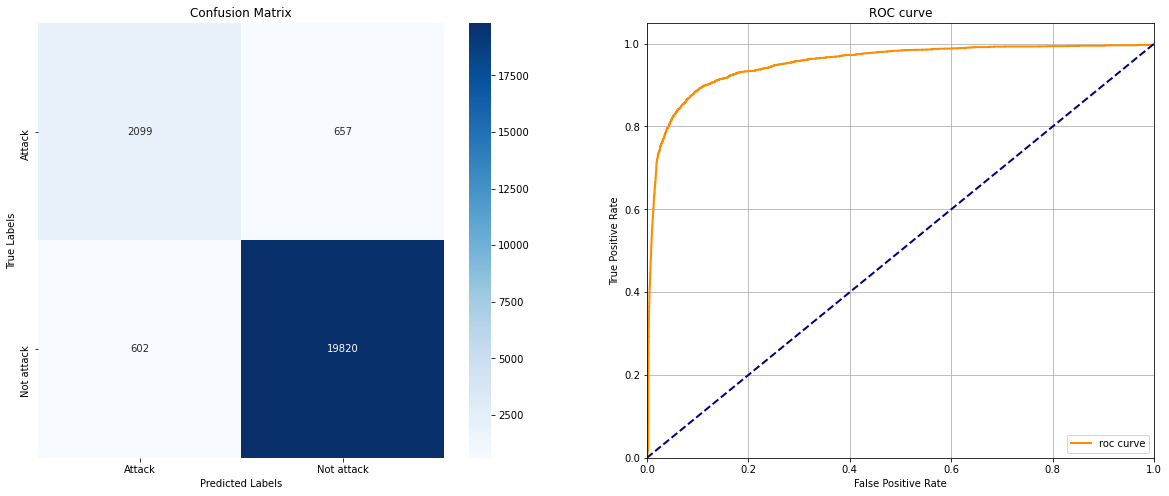

In [39]:
# test on attack comment data
from sklearn.metrics import roc_auc_score
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_true, y_prob_final)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm, tpr_rt_lm, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
prediction.metrics

{'eval_loss': 0.30704670766853165}

In [ ]:
len(test_data2400_dataset)

In [47]:
prediction_2400 = trainer.predict(test_data2400_dataset)

In [48]:
y_true_2400 = test_data2400_labels
y_prob_2400 = list(prediction_2400.predictions)

In [50]:
y_prob_final_2400 = []
y_pred_2400 = []
for i in range(len(y_prob_2400)):
    tempA = abs(y_prob_2400[i][0])
    tempB = abs(y_prob_2400[i][1])
    y_prob_final_2400.append(tempB/(tempA+tempB))
    if tempA > tempB:
        y_pred_2400.append(0)
    else:
        y_pred_2400.append(1)

Classification Report:
              precision    recall  f1-score   support

           1     0.4438    0.5649    0.4971       678
           0     0.7974    0.7075    0.7498      1641

    accuracy                         0.6658      2319
   macro avg     0.6206    0.6362    0.6234      2319
weighted avg     0.6940    0.6658    0.6759      2319



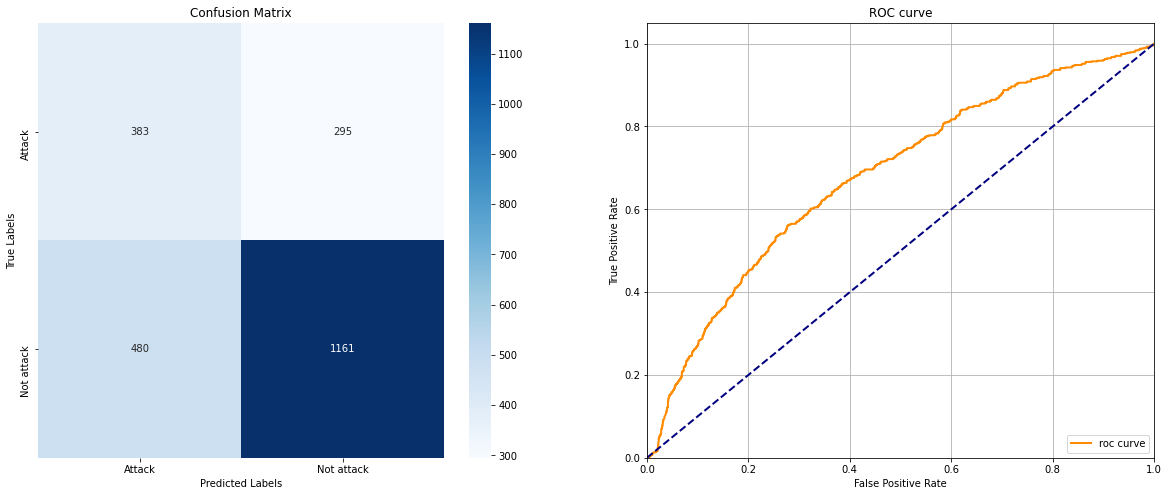

In [51]:
# test on 2400 hand labeled data 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
print('Classification Report:')
print(classification_report(y_true_2400, y_pred_2400, labels=[1,0], digits=4))

cm = confusion_matrix(y_true_2400, y_pred_2400, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm_2400, tpr_rt_lm_2400, _ = roc_curve(y_true_2400, y_prob_final_2400)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm_2400, tpr_rt_lm_2400, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [78]:
test_gab = pd.read_csv('Data/hate_test.csv',sep=',',encoding='utf-8')

In [79]:
test_gab.head()

,Hate_speech,Label
0,Look at this Soros funded relocation,0
1,It is beyond time to be done with their influe...,0
2,MartyGraw,0
3,Sara Carter’s report on DC judge ordering DOJ ...,0
4,Does ANYONE care what these immoral sick Holly...,0


In [80]:
test_gab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8300 entries, 0 to 8299
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Hate_speech  8296 non-null   object
 1   Label        8300 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 129.8+ KB


In [85]:
test_gab = test_gab.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

In [83]:
test_gab['Label'] = test_gab['Label'].astype(int)

In [84]:
test_gab_texts = list(test_gab['Hate_speech'])
test_gab_labels = list(test_gab['Label'])
test_gab_encodings = tokenizer(test_gab_texts, truncation=True, padding=True)
test_gab_dataset = LoadDataset(test_gab_encodings, test_gab_labels)

In [71]:
test_gab_dataset

In [72]:
prediction_test_gab = trainer.predict(test_gab_dataset)

In [73]:
y_true_gab = test_gab_labels
y_prob_gab = list(prediction_test_gab.predictions)

In [76]:
y_prob_final_gab = []
y_pred_gab = []
for i in range(len(y_prob_gab)):
    tempA = abs(y_prob_gab[i][0])
    tempB = abs(y_prob_gab[i][1])
    y_prob_final_gab.append(tempB/(tempA+tempB))
    if tempA > tempB:
        y_pred_gab.append(0)
    else:
        y_pred_gab.append(1)

Classification Report:
              precision    recall  f1-score   support

           1     0.0961    0.1298    0.1104       701
           0     0.9170    0.8874    0.9020      7599

    accuracy                         0.8234      8300
   macro avg     0.5066    0.5086    0.5062      8300
weighted avg     0.8477    0.8234    0.8351      8300



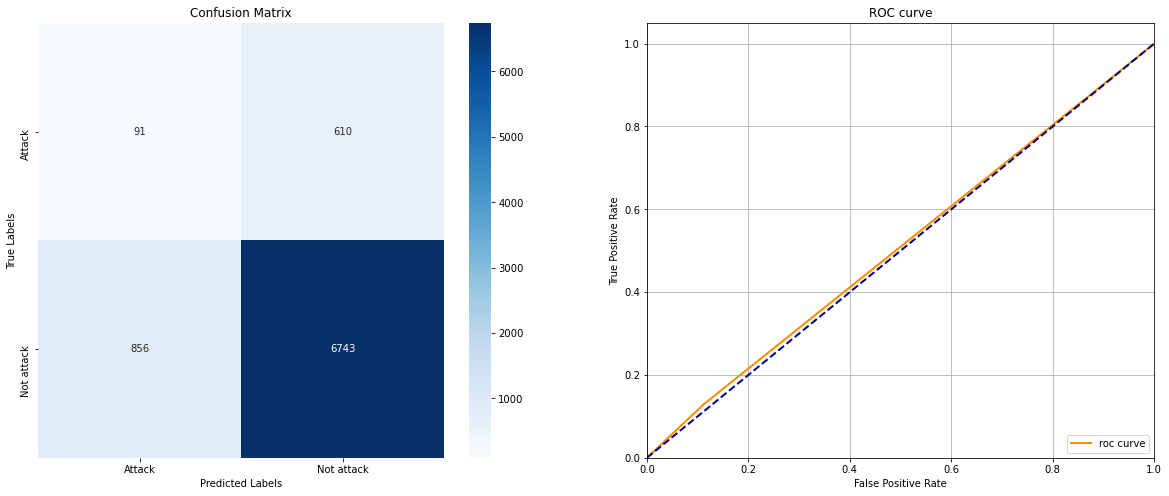

In [77]:
# test on gab data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
print('Classification Report:')
print(classification_report(y_true_gab, y_pred_gab, labels=[1,0], digits=4))

cm = confusion_matrix(y_true_gab, y_pred_gab, labels=[1,0])
plt.figure(1, figsize=(20,8))

ax= plt.subplot(121)
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Attack', 'Not attack'])
ax.yaxis.set_ticklabels(['Attack', 'Not attack'])
fpr_rt_lm_2400, tpr_rt_lm_2400, _ = roc_curve(y_true_gab, y_pred_gab)
plt.subplot(122)
lw = 2
plt.plot(fpr_rt_lm_2400, tpr_rt_lm_2400, color='darkorange',
         lw=lw, label='roc curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()